In [71]:
import pandas as pd
import numpy as np
from pypfopt import risk_models, expected_returns, plotting, EfficientFrontier
import matplotlib.pyplot as plt
from datetime import date
#pypfopt.__version__
import quantstats as qs
import yfinance as yf
import tempfile

https://medium.com/enjoy-algorithm/pre-processing-of-time-series-data-c50f8a3e7a98

https://www.kaggle.com/code/harshalnikose/portfolio-management
https://medium.com/cloudcraftz/portfolio-trading-using-pyportfolioopt-24040247249


In [ ]:
'''
the util in qs:

    def download_returns(ticker, period="max", proxy=None):
    params = {
        "tickers": ticker,
        "proxy": proxy,
    }
    if isinstance(period, _pd.DatetimeIndex):
        params["start"] = period[0]
    else:
        params["period"] = period
    return _yf.download(**params)["Close"].pct_change()
    '''

In [2]:
companies = [
"MSFT", 
"AMZN", 
"META", 
"BABA", 
"GE", 
"GOOG", 
"AMD", 
"WMT", 
"BAC", 
"GM", 
"T", 
"UAA", 
"MA", 
"PFE", 
"JPM", 
"SBUX"]

In [83]:
def test_ef():
    companies = ["MSFT", "AMZN", "META", "BABA", "GE", "GOOG", "AMD", "WMT", "BAC", "GM", "T", "UAA", "MA", "PFE", "JPM", "SBUX"]
    stock_data = yf.download(companies, start="2020-6-01", end=date.today())
    stock_data = stock_data["Adj Close"]
    mu2 = expected_returns.mean_historical_return(stock_data)
    cov_matrix2 = risk_models.sample_cov(stock_data)
    temp_ef = EfficientFrontier(mu2, cov_matrix2, weight_bounds=(None, None))
    return temp_ef

In [13]:
temp = qs.utils.download_returns(companies)

[*********************100%%**********************]  16 of 16 completed


In [8]:
stock_data = yf.download(companies, start="2020-6-01", end=date.today())

[*********************100%%**********************]  16 of 16 completed


In [9]:
stock_data = stock_data["Adj Close"]

In [10]:
stock_data

,AMD,AMZN,BABA,BAC,GE,GM,GOOG,JPM,MA,META,MSFT,PFE,SBUX,T,UAA,WMT
Date,,,,,,,,,,,,,,,,
2020-06-01,53.630001,123.552002,206.570007,22.606798,41.634190,26.610432,71.591003,88.844460,295.633850,231.910004,177.514725,29.800730,73.369339,17.667109,9.26,117.848839
2020-06-02,53.540001,123.620499,214.330002,22.818075,43.420273,27.074680,71.960999,89.141815,297.781952,232.720001,179.534271,30.389011,72.863457,17.701380,9.41,117.829819
2020-06-03,52.730000,123.919998,218.610001,23.874468,45.329533,28.714371,71.819000,93.953461,301.195374,230.160004,179.971191,30.389011,74.549690,17.998404,10.30,117.382988
2020-06-04,52.630001,123.029999,218.039993,24.771727,47.669907,28.803272,70.609001,95.908768,295.604401,226.289993,177.602158,30.262953,73.762787,18.164051,10.41,116.090034
2020-06-05,53.099998,124.150002,219.550003,26.001987,48.532158,30.235535,71.919502,100.224854,305.913330,230.770004,181.757675,30.246145,76.947861,18.718107,11.10,115.567139
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-31,98.500000,133.089996,82.540001,26.340000,108.629997,28.200001,125.300003,139.059998,376.350006,301.269989,338.109985,30.559999,92.239998,15.400000,6.85,163.410004
2023-11-01,108.040001,137.000000,82.480003,26.400000,107.250000,28.000000,127.570000,138.940002,377.820007,311.850006,346.070007,30.510000,91.349998,15.580000,6.77,164.869995
2023-11-02,107.830002,138.070007,83.410004,27.620001,107.779999,28.799999,128.580002,141.419998,382.690002,310.869995,348.320007,30.500000,100.010002,15.730000,7.01,165.520004


In [11]:
mu2 = expected_returns.mean_historical_return(stock_data)
print(mu2)

AMD     0.238475
AMZN    0.036520
BABA   -0.226992
BAC     0.067954
GE      0.333384
GM      0.026500
GOOG    0.193665
JPM     0.151255
MA      0.080931
META    0.094120
MSFT    0.225272
PFE     0.013268
SBUX    0.107078
T      -0.032910
UAA    -0.074462
WMT     0.102778
dtype: float64


<Axes: xlabel='Date'>

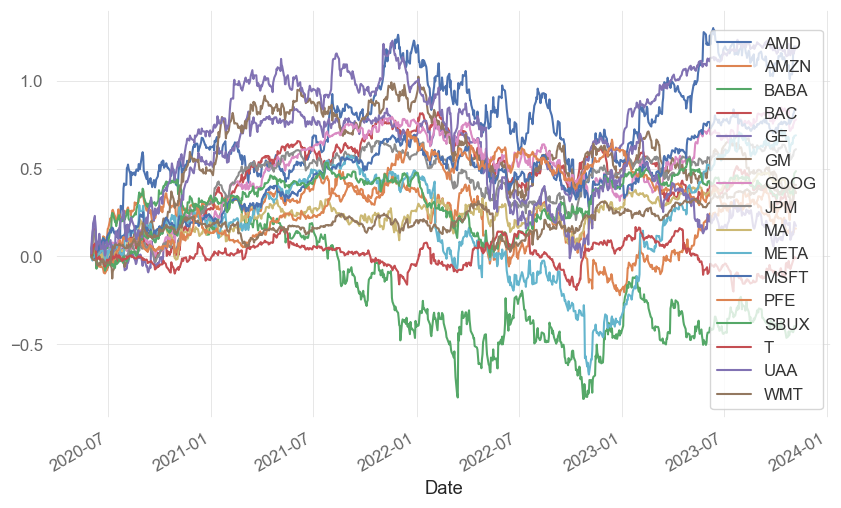

In [12]:
stock_data.pct_change()[1:].cumsum().plot()

In [13]:
cov_matrix2 = risk_models.sample_cov(stock_data)
print(cov_matrix2)
type(cov_matrix2)

           AMD      AMZN      BABA       BAC        GE        GM      GOOG  \
AMD   0.268094  0.108676  0.082100  0.039684  0.039694  0.061769  0.089585   
AMZN  0.108676  0.141665  0.062286  0.029497  0.027409  0.042359  0.079219   
BABA  0.082100  0.062286  0.292447  0.034558  0.034818  0.056760  0.051302   
BAC   0.039684  0.029497  0.034558  0.095596  0.060639  0.069137  0.031599   
GE    0.039694  0.027409  0.034818  0.060639  0.120885  0.072033  0.029652   
GM    0.061769  0.042359  0.056760  0.069137  0.072033  0.157926  0.044994   
GOOG  0.089585  0.079219  0.051302  0.031599  0.029652  0.044994  0.099334   
JPM   0.032021  0.023729  0.029955  0.074160  0.054902  0.060086  0.027794   
MA    0.061061  0.047707  0.044678  0.040802  0.043210  0.049759  0.046467   
META  0.117241  0.106006  0.083953  0.034873  0.033507  0.051450  0.095146   
MSFT  0.088613  0.073758  0.043159  0.023560  0.021801  0.035637  0.065922   
PFE   0.015583  0.010636  0.002543  0.018439  0.014867  0.016880

pandas.core.frame.DataFrame

<Axes: >

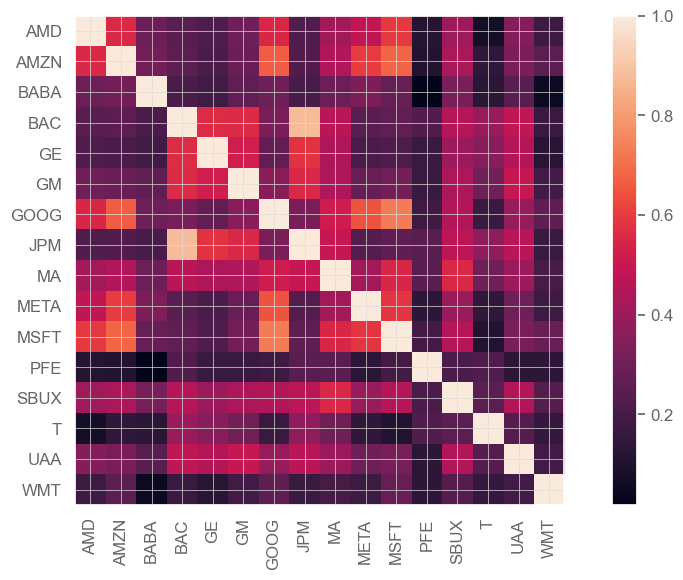

In [15]:
plotting.plot_covariance(cov_matrix2, plot_correlation=True)

In [16]:
ef = EfficientFrontier(mu2, cov_matrix2)
ef.max_sharpe()

OrderedDict([('AMD', 0.0),
             ('AMZN', 0.0),
             ('BABA', 0.0),
             ('BAC', 0.0),
             ('GE', 0.4615044820823627),
             ('GM', 0.0),
             ('GOOG', 0.0),
             ('JPM', 0.0),
             ('MA', 0.0),
             ('META', 0.0),
             ('MSFT', 0.3622056017166876),
             ('PFE', 0.0),
             ('SBUX', 0.0),
             ('T', 0.0),
             ('UAA', 0.0),
             ('WMT', 0.17628991620095)])

<Axes: >

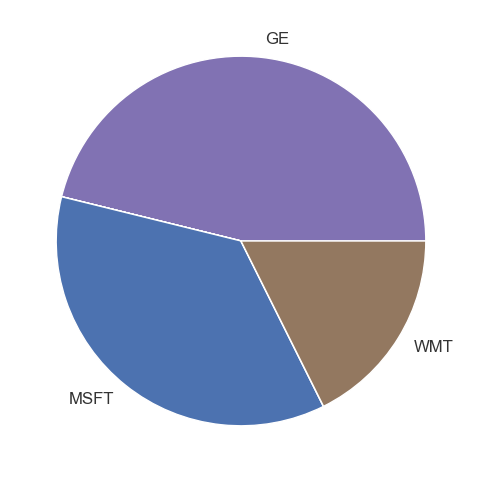

In [17]:
weights = ef.clean_weights()
pd.Series(weights).plot.pie()

In [18]:
ef.portfolio_performance(verbose=True)

Expected annual return: 25.4%
Annual volatility: 22.1%
Sharpe Ratio: 1.06


(0.2535718963037599, 0.22050307633206764, 1.0592681979275937)

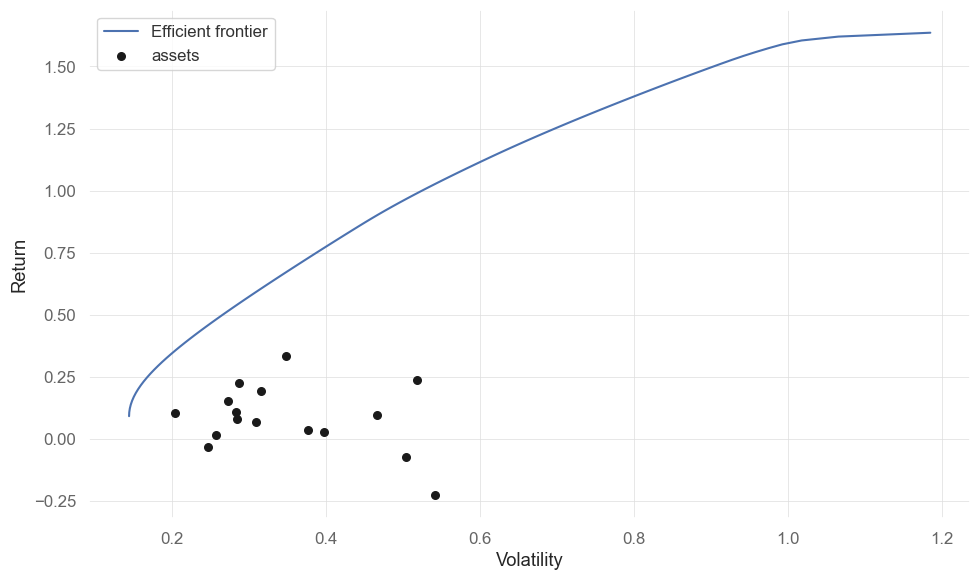

In [23]:
ef = EfficientFrontier(mu2, cov_matrix2, weight_bounds=(None, None))

fig, ax = plt.subplots()
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=True)
plt.show()

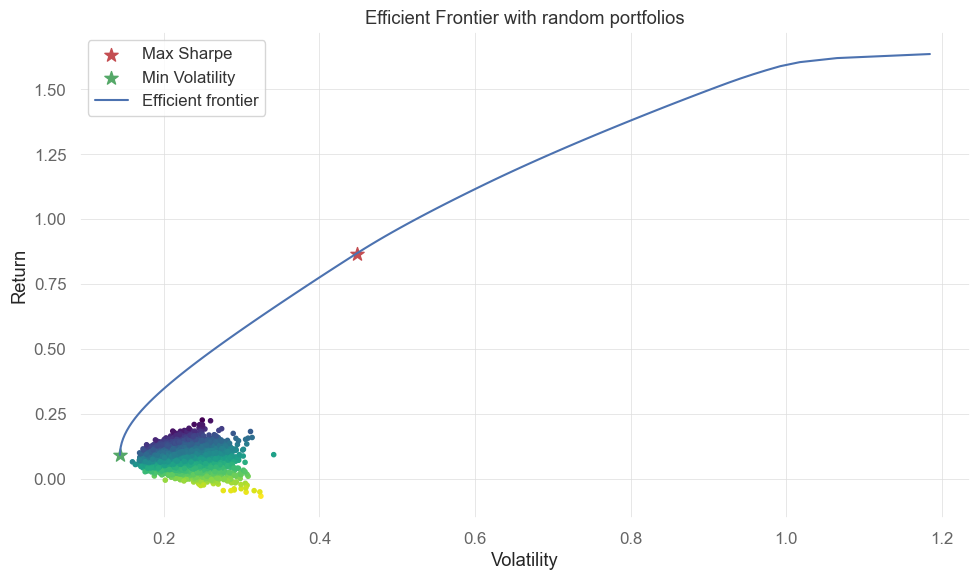

In [80]:
ef = EfficientFrontier(mu2, cov_matrix2, weight_bounds=(None, None))
fig, ax = plt.subplots()
ef_max_sharpe = ef.deepcopy()


# Find the tangency portfolio
ef_max_sharpe.max_sharpe()
ret_tangent, std_tangent, _ = ef_max_sharpe.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Max Sharpe")

# Min Volatility
ef_min_vol = ef.deepcopy()
ef_min_vol.min_volatility()
vol_ret, vol_std, _ = ef_min_vol.portfolio_performance()
ax.scatter(vol_std, vol_ret, marker="*", s=100, c="g", label="Min Volatility")

plotting.plot_efficient_frontier(ef, ax=ax, show_assets=False)

# Generate random portfolios
n_samples = 10000
w = np.random.dirichlet(np.ones(ef.n_assets), n_samples)
rets = w.dot(ef.expected_returns)
stds = np.sqrt(np.diag(w @ ef.cov_matrix @ w.T))
sharpes = rets / stds
ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")

# Output
ax.set_title("Efficient Frontier with random portfolios")
ax.legend()
plt.tight_layout()
plt.show()

In [68]:
ef = EfficientFrontier(mu2, cov_matrix2, weight_bounds=(None, None))


def plot_ef_with_random(ef, output=None, n_samples=10000):
    fig, ax = plt.subplots()
    ef_max_sharpe = ef.deepcopy()
    ef_min_vol = ef.deepcopy()

    # Find the tangency portfolio
    ef_max_sharpe.max_sharpe()
    ret_tangent, std_tangent, _ = ef_max_sharpe.portfolio_performance()
    ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Max Sharpe")

    # Min Volatility
    ef_min_vol.min_volatility()
    vol_ret, vol_std, _ = ef_min_vol.portfolio_performance()
    ax.scatter(vol_std, vol_ret, marker="*", s=100, c="g", label="Min Volatility")


    # Generate random portfolios
    w = np.random.dirichlet(np.ones(ef.n_assets), n_samples)
    rets = w.dot(ef.expected_returns)
    stds = np.sqrt(np.diag(w @ ef.cov_matrix @ w.T))
    sharpes = rets / stds
    ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")

    # Output
    plotting.plot_efficient_frontier(ef, ax=ax, show_assets=False)
    ax.set_title("Efficient Frontier with random portfolios")
    ax.legend()
    plt.tight_layout()
    
    st.pyplot(fig)

In [78]:
def plot_ef_with_random(ef, output=None, n_samples=10000):
    fig, ax = plt.subplots()
    ef_max_sharpe = ef.deepcopy()
    ef_min_vol = ef.deepcopy()

    # Find the tangency portfolio
    ef_max_sharpe.max_sharpe()
    ret_tangent, std_tangent, _ = ef_max_sharpe.portfolio_performance()
    ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Max Sharpe")

    # Min Volatility
    ef_min_vol.min_volatility()
    vol_ret, vol_std, _ = ef_min_vol.portfolio_performance()
    ax.scatter(vol_std, vol_ret, marker="*", s=100, c="g", label="Min Volatility")


    # Generate random portfolios
    w = np.random.dirichlet(np.ones(ef.n_assets), n_samples)
    rets = w.dot(ef.expected_returns)
    stds = np.sqrt(np.diag(w @ ef.cov_matrix @ w.T))
    sharpes = rets / stds
    ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")

    # Output
    plotting.plot_efficient_frontier(ef, ax=ax, show_assets=False)
    ax.set_title("Efficient Frontier with random portfolios")
    ax.legend()
    plt.tight_layout()
    plt.show()

[*********************100%%**********************]  16 of 16 completed


C:\Users\leung\Anaconda3\envs\portfolio\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


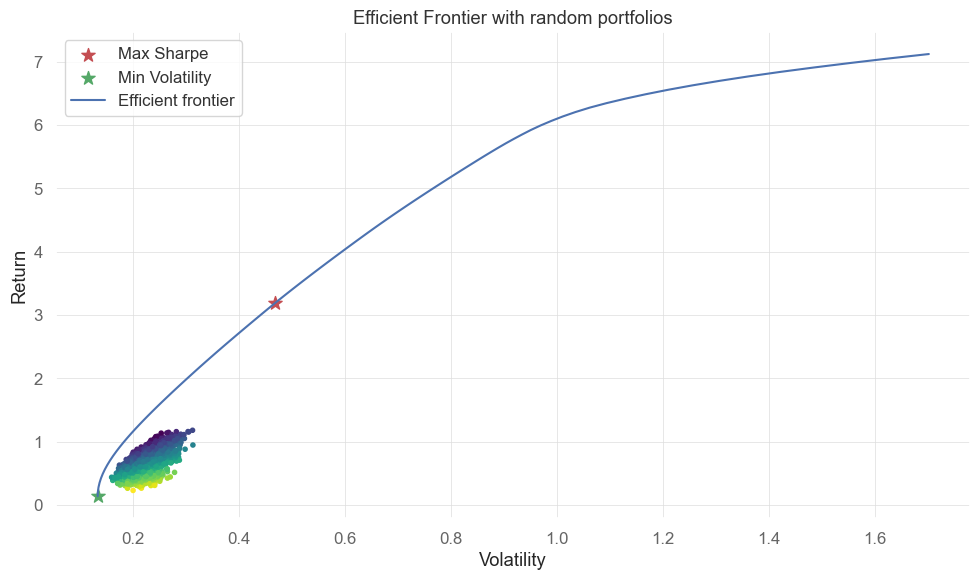

In [84]:
plot_ef_with_random(test_ef())